In [1]:
import cirq
import numpy as np
import pickle
import json
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
from qiskit import transpile
from qiskit.providers.aer import QasmSimulator

#define utility functions

def simulate(circuit: cirq.Circuit) -> dict:
    """This funcion simulate a cirq circuit (without measurement) and output results in the format of histogram.
    """
    simulator = cirq.Simulator()
    result = simulator.simulate(circuit)
    
    state_vector=result.final_state_vector
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram

def simulate_qiskit(circuit, n_shots=1024) -> dict:
    """This funcion simulate a cirq circuit (without measurement) and output results in the format of histogram.
    """

    circuit.measure_all()
    simulator = QasmSimulator()

    compiled_circuit = transpile(circuit, simulator)
    job = simulator.run(compiled_circuit, shots=n_shots)
    
    result = job.result()
    
    histogram = result.get_counts(compiled_circuit)
    
    return histogram


def histogram_to_category(histogram):
    """This function take a histogram representations of circuit execution results, and process into labels as described in 
    the problem description."""
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive

def count_gates(circuit: cirq.Circuit):
    """Returns the number of 1-qubit gates, number of 2-qubit gates, number of 3-qubit gates...."""
    counter=Counter([len(op.qubits) for op in circuit.all_operations()])
    
    #feel free to comment out the following two lines. But make sure you don't have k-qubit gates in your circuit
    #for k>2
    for i in range(2,20):
        assert counter[i]==0
        
    return counter

def count_gates_qiskit(circuit: cirq.Circuit):
    """Returns the number of 1-qubit gates, number of 2-qubit gates, number of 3-qubit gates...."""
    counter=Counter([len(op.qubits) for op in circuit.all_operations()])
    
    #feel free to comment out the following two lines. But make sure you don't have k-qubit gates in your circuit
    #for k>2
    #for i in range(2,20):
    #    assert counter[i]==0
        
    return counter

def image_mse(image1,image2):
    # Using sklearns mean squared error:
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
    return mean_squared_error(image1, image2)


In [55]:
#load the mock data (for testing only)
files=os.listdir("mock_data")
dataset=list()
for file in files:
    with open('mock_data/'+file, "r") as infile:
        loaded = json.load(infile)
        dataset.append(loaded)

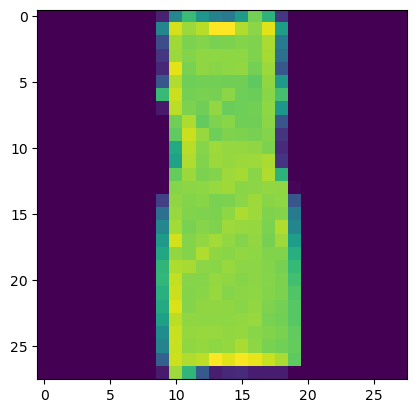

In [3]:
#load the actual hackthon data (fashion-mnist)
images=np.load('data/images.npy')
labels=np.load('data/labels.npy')
#you can visualize it
import matplotlib.pyplot as plt
plt.imshow(images[1100])

In [3]:
#test part1

import part1
from importlib import reload
reload(part1)

from part1 import *

n_shots = 102400

#load the mock data (for testing only)
files=os.listdir("mock_data")
dataset=list()
for file in files:
    with open('mock_data/'+file, "r") as infile:
        loaded = json.load(infile)
        dataset.append(loaded)

n_qubits = np.ceil(2*np.log2(np.array(dataset[0]['image']).shape[1])).astype(int)

n=len(dataset)
mse=0
gatecount=0

for data in dataset[:2]:
    # encode image into circuit
    # circuit=encode_cirq(data['image'])
    data_input = np.array(data['image']).flatten()

    circuit = encode_qiskit(data_input, n_qubits=n_qubits)

    print(circuit.draw())
    print(print(dict(circuit.count_ops())))
    
    #simulate circuit
    #histogram=simulate(circuit)
    histogram = simulate_qiskit(circuit, n_shots=n_shots)

    # recover color
    recovered_image_cos = np.zeros(len(data_input))
    recovered_image_sin = np.zeros(len(data_input))

    for key in histogram:
        idx_bin = key[1:]
        idx = int(idx_bin,2)
        if key[0] == '0':
            recovered_image_cos[idx] = histogram[key]
        else:
            recovered_image_sin[idx] = histogram[key]

    print(np.array(data['image']))
    prob = recovered_image_sin/(recovered_image_sin+recovered_image_cos)
    print(np.sqrt(prob)*510/np.pi)
    
    #count the number of 2-qubit gates
    #gatecount+=count_gates(circuit)[2]
    
    #reconstruct the image
    image_re = decode(histogram)
    
    #calculate mse
    #mse+=image_mse(data['image'],image_re)
    
#fidelity of reconstruction
f=1-mse
gatecount=gatecount/n

#score for part1 
print(f*(0.999**gatecount))

CircuitError: 'invalid control state specification: 3'

In [147]:
#grade part1

import part1
from importlib import reload
reload(part1)

from part1 import *

n_shots = 102400

dataset = images

n_qubits = np.ceil(2*np.log2(dataset.shape[1])).astype(int)

n=len(dataset)
mse=0
gatecount=0

for data in dataset[:2]:
    # encode image into circuit
    # circuit=encode_cirq(data['image'])
    # data_input = np.array(data['image']).flatten()

    data_input = data.flatten()

    circuit = encode_qiskit(data_input, n_qubits=n_qubits)

    print(circuit.draw())
    print(print(dict(circuit.count_ops())))
    
    #simulate circuit
    #histogram=simulate(circuit)
    histogram = simulate_qiskit(circuit, n_shots=n_shots)

    # recover color
    recovered_image_cos = np.zeros(len(data_input))
    recovered_image_sin = np.zeros(len(data_input))

    for key in histogram:
        idx_bin = key[1:]
        idx = int(idx_bin,2)
        if key[0] == '0':
            recovered_image_cos[idx] = histogram[key]
        else:
            recovered_image_sin[idx] = histogram[key]

    print(np.array(data['image']))
    prob = recovered_image_sin/(recovered_image_sin+recovered_image_cos)
    print(np.sqrt(prob)*510/np.pi)
    
    #count the number of 2-qubit gates
    #gatecount+=count_gates(circuit)[2]
    
    #reconstruct the image
    image_re = decode(histogram)
    
    #calculate mse
    #mse+=image_mse(data['image'],image_re)
    
#fidelity of reconstruction
f=1-mse
gatecount=gatecount/n

#score for part1 
print(f*(0.999**gatecount))

10


CircuitError: 'invalid control state specification: 1023'

In [89]:
#grade part 2

#load classifier circuit
with open('part2.pickle', 'rb') as f:
    classifier=pickle.load(f)
    
score=0


for data in dataset:
    #encode image into circuit
    circuit=encode_cirq(data['image'])
    
    #append with classifier circuit
    
    circuit.append(classifier)
    
    #simulate circuit
    histogram=simulate(circuit)
    
    #count the gate used in the circuit for score calculation
    gatecount+=count_gates(circuit)[2]
    
    #convert histogram to category
    cat=histogram_to_category(histogram)
        
    if cat==data['category']:
        score+=1
#score
score=score/n
gatecount=gatecount/n

print(score*(0.999**gatecount))

AttributeError: 'NoneType' object has no attribute 'append'

In [85]:
def x_gate_generation(n_qubits):
    x_gate_seq = []
    i = 1
    while i <= n_qubits:
        x_gate_seq = x_gate_seq + [i] + x_gate_seq
        i += 1

    return x_gate_seq

print(x_gate_generation(4))

[1, 2, 1, 3, 1, 2, 1, 4, 1, 2, 1, 3, 1, 2, 1]
